In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `/Volumes/Chenyi/MIT/mosquito_inference/MosquitoProject`


In [2]:
using MosquitoProject
using DelimitedFiles,LinearAlgebra,
      StatsBase, DifferentialEquations, Plots

default(grid=false,legend=false, size=(400,320), 
        dpi=300, tickfontsize=16, lw=2, labelfontsize=16, tickdir=:out, fontfamily="Arial", legendfontsize=13)

[ Info: Precompiling MosquitoProject [81638d68-bacb-4361-b6cc-f3b1695bb2fa]


In [3]:
CENTER_COORDS = [0. 0. 0.]

# define the ground-truth model
function define_model_true(; ndim=3, f1=LaguerreFunction{Float64}(), n1=collect(0:5), p1=ones(1), c1=zeros(length(n1)), bfield1=nullfunc!,
                        f2a=LaguerreFunction{Float64}(), f2b=LaguerreFunction{Float64}(), f2ab=LegendreP{Float64}(),
                        n2a=collect(0:5), n2b=collect(0:5), n2ab=collect(0:5), c2=zeros(length(n2a)*length(n2b)*length(n2ab)),
                        p2=ones(2), bfield2=nullfunc!, D=0.0)
    
    model=MosquitoModel(; ndim=ndim, f1=f1, f2a=f2a, f2b=f2b, f2ab=f2ab);

    model.islearned[:visual] = false
    model.islearned[:velpot] = true
    model.funcs[:velpot] = [Ψ1(f1, n, :a) for n in [0, 2]];
    model.coeffs[:velpot]= [0.5, -0.5];
    model.params[:velpot] = [1.0]
    model.diffD = D
    
    return model

end


# define the inference model
function define_model_learn(; ndim=3, f1=LaguerreFunction{Float64}(), n1=collect(0:5), p1=ones(1), c1=zeros(length(n1)), bfield1=nullfunc!,
                        f2a=LaguerreFunction{Float64}(), f2b=LaguerreFunction{Float64}(), f2ab=LegendreP{Float64}(),
                        n2a=collect(0:5), n2b=collect(0:5), n2ab=collect(0:5), c2=zeros(length(n2a)*length(n2b)*length(n2ab)),
                        p2=ones(2), bfield2=nullfunc!, D=0.0)
    
    model=MosquitoModel(; ndim=ndim, f1=f1, f2a=f2a, f2b=f2b, f2ab=f2ab);

    model.islearning[:velpot] = true
    model.funcs[:velpot] = [Ψ1(f1, n, :a) for n in n1];
    model.coeffs[:velpot]= zeros(length(model.funcs[:velpot]))
    model.params[:velpot] = [1.0]
    
    return model

end

define_model_learn (generic function with 1 method)

In [4]:
# sample initial conditions for artificial trajectories
function sample_init(; v₀ = 1.0, σᵥ = 0.2 )
    ρ =  cbrt(rand())*2
#     v =  v₀ + σᵥ * randn()
    v = rand()*1.5
    
    x1, y1, z1 =  randn(), randn(), randn()
    n1 = sqrt(x1^2 + y1^2 + z1^2)
    x1 /= n1
    y1 /= n1
    z1 /= n1
    
    x2, y2, z2 =  randn(), randn(), randn()
    n2 = sqrt(x2^2 + y2^2 + z2^2)
    x2 /= n2
    y2 /= n2
    z2 /= n2
    
    return [ρ*x1, ρ*y1, ρ*z1, v*x2, v*y2, v*z2]
end

sample_init (generic function with 1 method)

In [5]:
function gen_simulation_data(u0s, Ts, model; dts=0.01, solver=SOSRA())
    simTs, simPos, simVel  = sde_sim(model, u0s, Ts, solver; dts=dts);
    return convert(Vector{Array{Float64}}, simTs), simPos, simVel
end

gen_simulation_data (generic function with 1 method)

In [6]:
function inference_pipeline(x, v, t, model, vv; force_type=:velpot, cutoff=0.1, dts=0.01)
    
    P = MosquitoInference(x, v, t, model);
    init_mosquitoinference(P);
    res = sparse_bayesian_fit(P, [1.0], force_type; MAX_ITERS=100)
    
    D_learn = 0.0
    count = 1
    cov = zeros(size(P.G)[2],size(P.G)[2])
    while true
        coeffs_old = copy(P.coef_full);
        res_this = SBLvar( P.G[:, P.bigind], P.b, MAX_ITERS=100);
        fill!(P.coef_full, 0.0)
        copy!(@view(P.coef_full[P.bigind]), res_this[2])
        P.bigind = abs.(P.coef_full) .> cutoff;
        P.coef_full[.!(P.bigind)] .= 0.0;
        cov = res_this[3]
        D_learn = exp(2*res_this[1])*dts
        println("itr=$count: n=$(sum(P.bigind)), D=$(exp(2*res_this[1])*dts)")
        count += 1
        if maximum(abs.(P.coef_full .- coeffs_old)) < 1e-6 || sum(P.bigind) == 0
            break
        end
    end
    
    # reconstructing force
    lib_vv = zeros(length(vv), sum(P.bigind))
    n_vv = findall(P.bigind)
    for col in axes(lib_vv, 2)
        lib_vv[:, col] = LaguerreFunction{Float64}().(n_vv[col]-1, vv, P.model.params[force_type][1])
    end
    frec = lib_vv * P.coef_full[P.bigind]
    fvar = diag( lib_vv * cov * lib_vv' )
    
    model.coeffs[force_type] = P.coef_full;
    model.islearned[force_type] = true
    model.diffD = D_learn;
    
    return frec, fvar
end

inference_pipeline (generic function with 1 method)

In [7]:
# generate N trajectories as input data
N = 500
u0s = [sample_init() for _ in 1:N] # initial conditions
Ts = [(0.0, 10.0) for _ in 1:N]    # durations

model_true = define_model_true(; f1=Polynomial(), D=0.25);

simTs, simPos, simVel  = gen_simulation_data(u0s, Ts, model_true)

# the inference pipeline takes trajectory data as input data and learn the dynamical model that fits the data
vv = collect(0:0.01:1.5);
model_learn = define_model_learn(; f1=LaguerreFunction{Float64}());
frec, fvar = inference_pipeline(simPos, simVel, simTs, model_learn, vv)

# resimulate the learned model
outTs, outPos, outVel  = gen_simulation_data(u0s, Ts, model_learn);

# analyze speed of the trajectories
simSpeeds = [sqrt.(sum(abs2, simVel[i], dims=2)) for i in 1:N];
outSpeeds = [sqrt.(sum(abs2, outVel[i], dims=2)) for i in 1:N];

itr=1: n=4, D=0.24854294648047887
itr=2: n=4, D=0.24854294737105398
itr=3: n=4, D=0.24854294737105398


### Plot: input trajectories

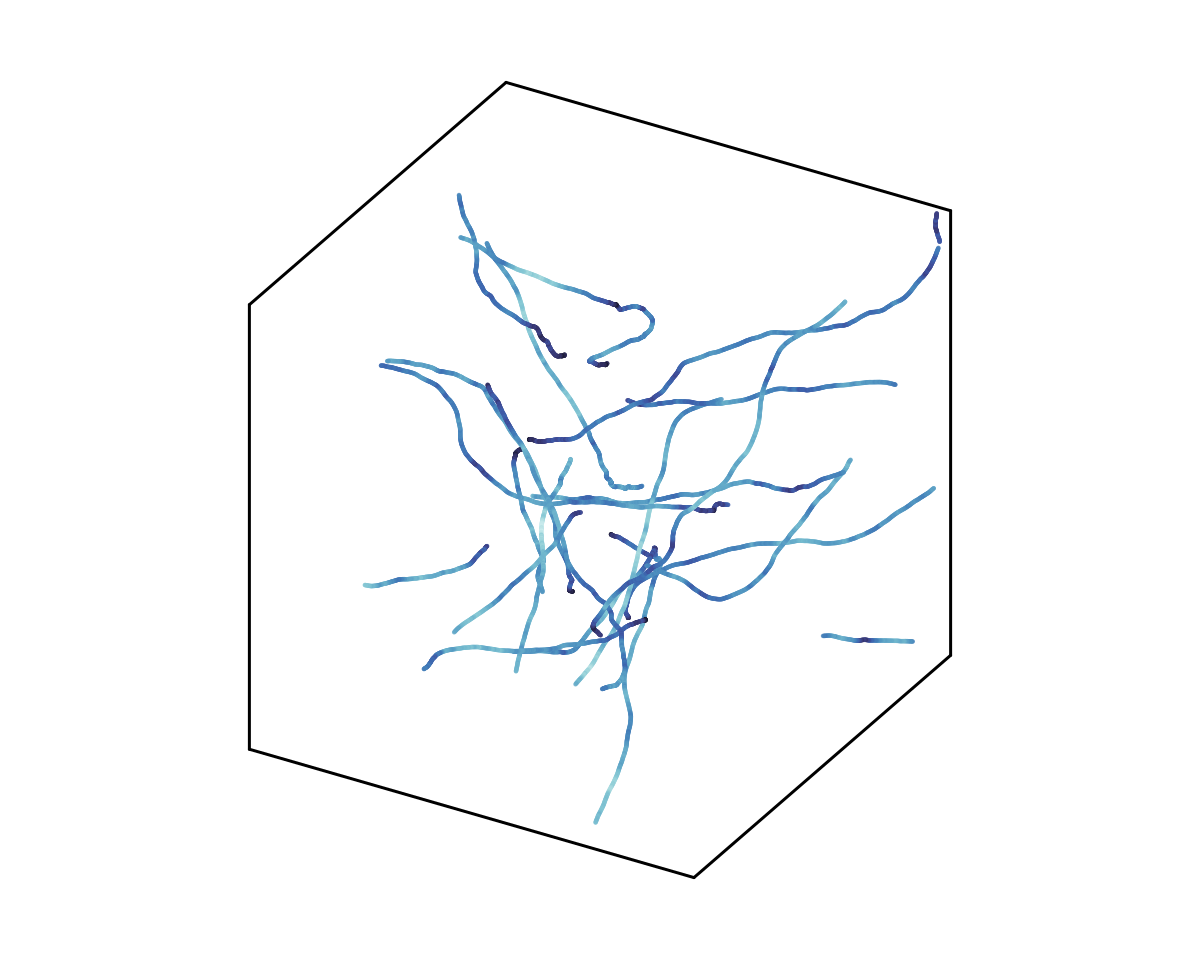

In [8]:
fig_demo_input = plot();
for i in 1:25:N
    plot!(fig_demo_input, simPos[i][:,1], simPos[i][:,2], simPos[i][:,3], lw=1.5, alpha=0.8, line_z = simSpeeds[i], cmap = :ice, clim=(0.0, 2.0))
end
plot!(fig_demo_input; xlim=(-3,3),ylim=(-3,3),zlim=(-3,3), framestyle=:box, xtick=[], ytick=[], ztick=[])

### Plot: output trajectories

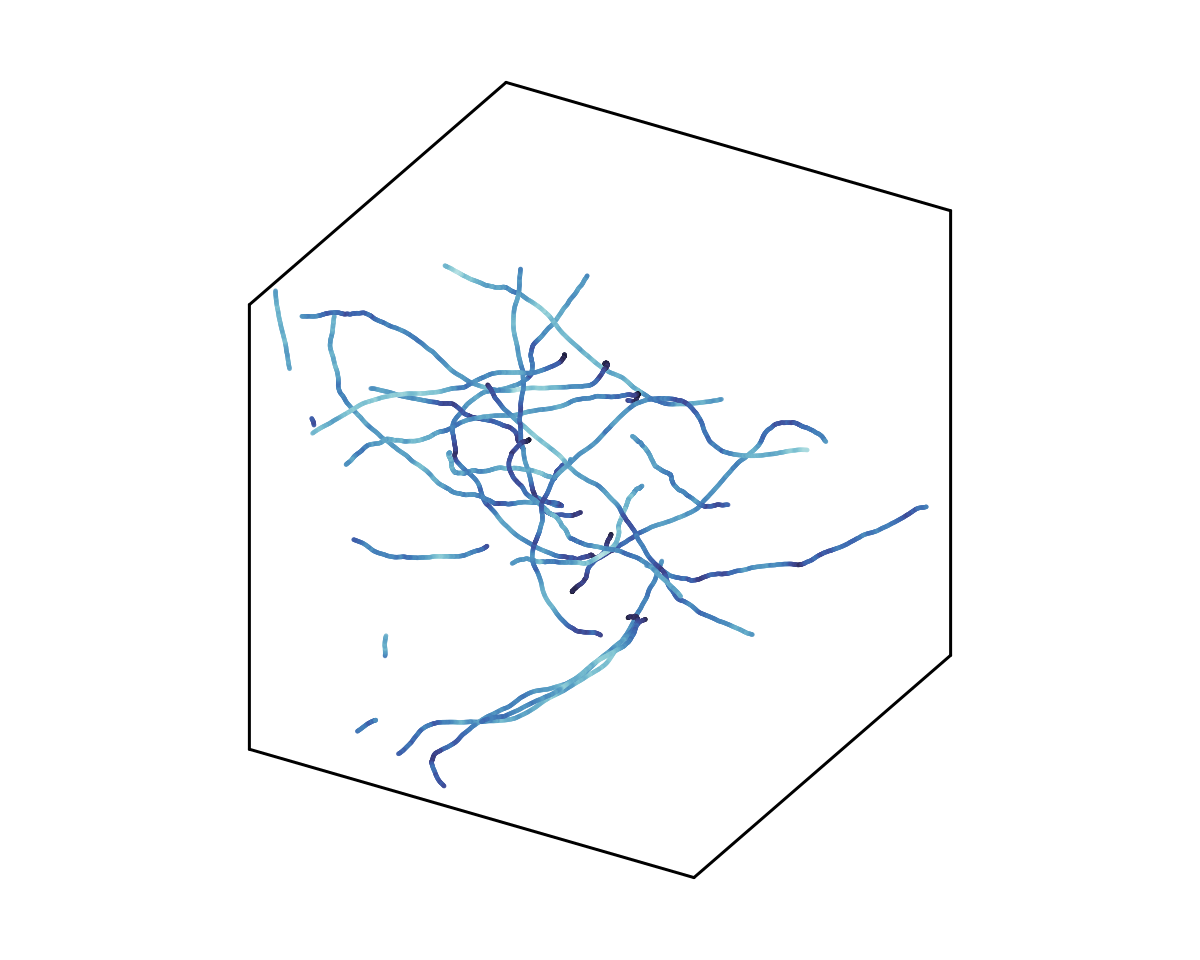

In [9]:
fig_demo_output = plot();
for i in 1:25:N
    plot!(fig_demo_output, outPos[i][:,1], outPos[i][:,2], outPos[i][:,3], lw=1.5, alpha=0.8, line_z = outSpeeds[i], cmap = :ice, clim=(0.0, 2.0))
end
plot!(fig_demo_output; xlim=(-3,3),ylim=(-3,3),zlim=(-3,3), framestyle=:box, xtick=[], ytick=[], ztick=[])

### Plot: learned vs true α(v)

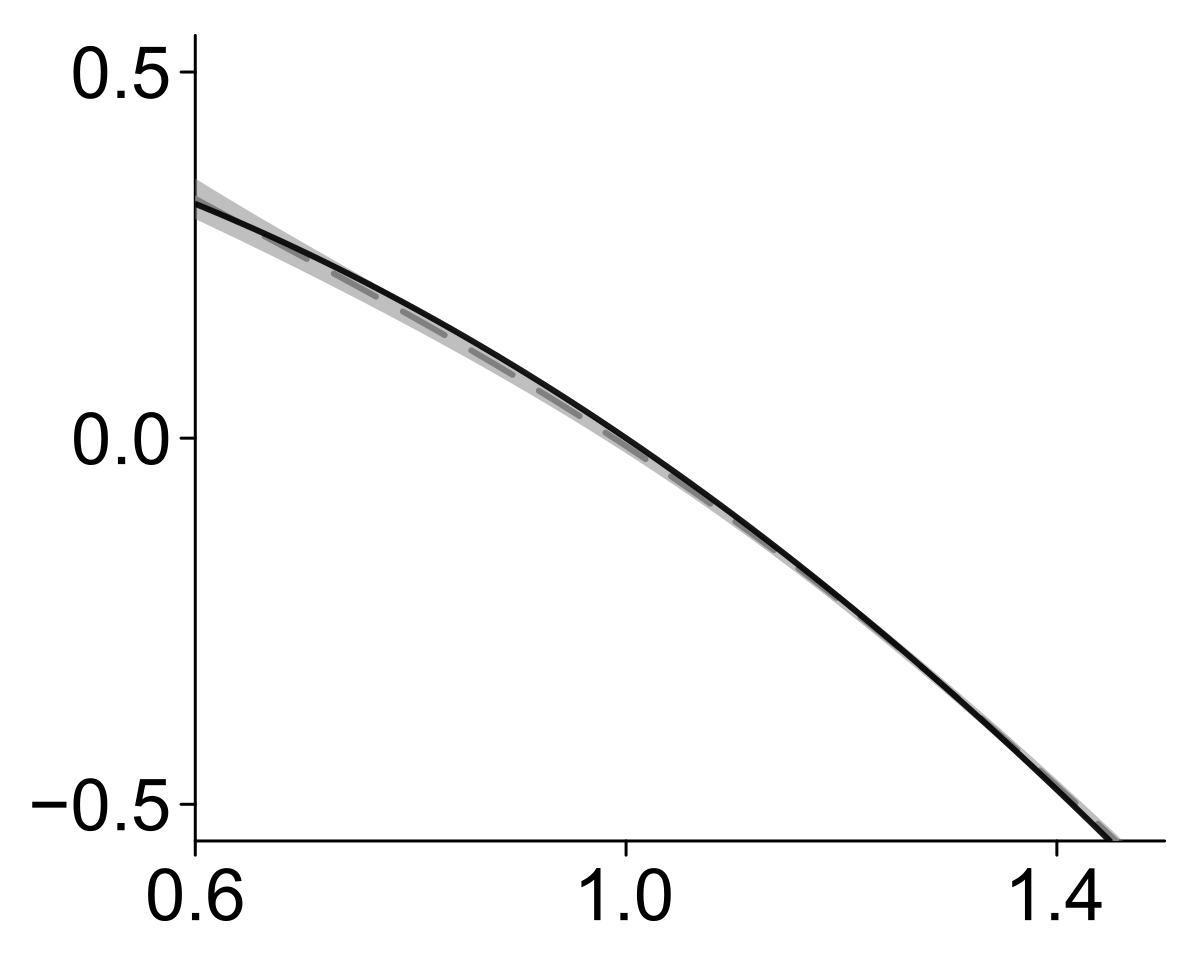

In [10]:
plot(vv, frec; ribbon=sqrt.(fvar), c = :gray, lw=2, background_color=:transparent, ls=:dash) 
plot!(vv, 0.5 .- 0.5*vv.^2, ylim=(-0.55, 0.55), xlim=(0.6, 1.5), 
        lc=:black, xtick=[0.6,1.0,1.4],ytick=[-0.5, 0., 0.5], alpha=0.9)
current()

### Plot: input data vs learned model - speed PDFs 

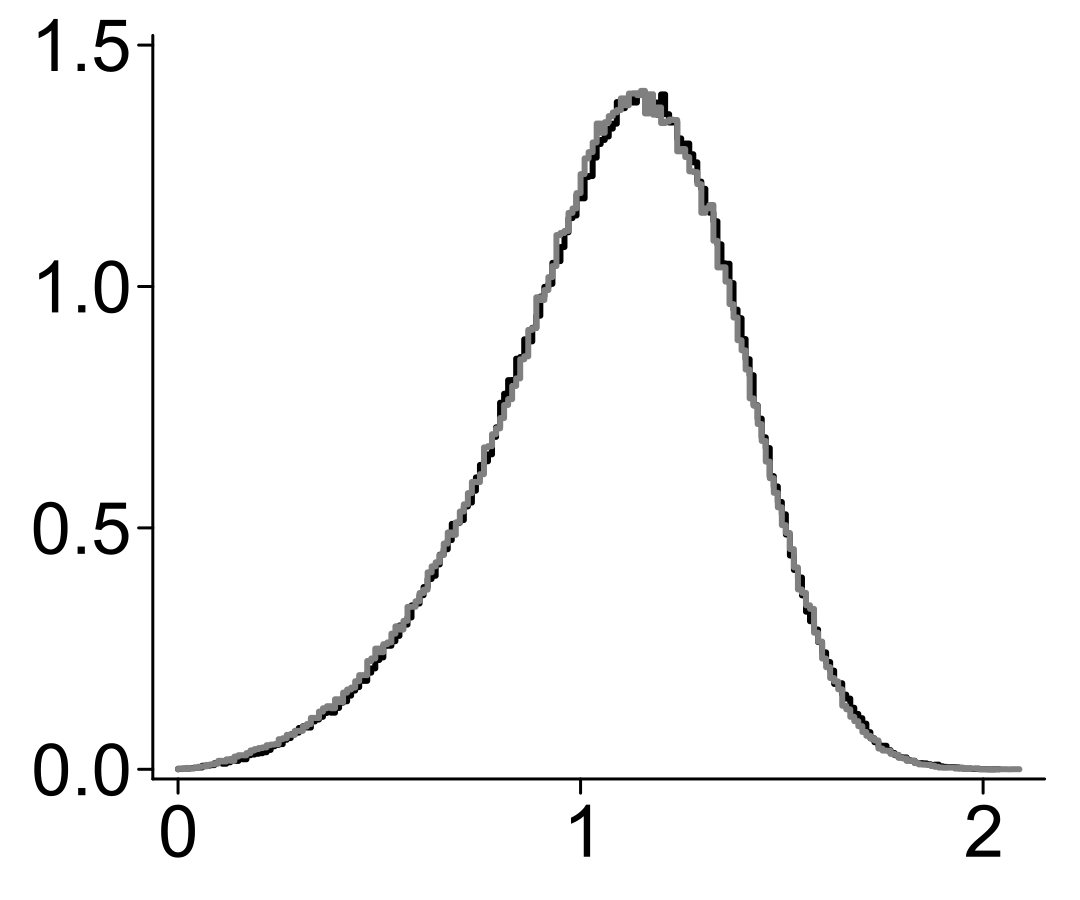

In [11]:
stephist(vcat(simSpeeds...),normalize=true, lc=:black, xtick=[0.0, 1.0, 2.0], background_color=:transparent, size=(360,300))
stephist!(vcat(outSpeeds...),normalize=true,lc=:gray, ytick=[0, 0.5, 1, 1.5],ylim=(-0.02,1.52))
current()

### Plot: input data vs learned model - MSD

In [12]:
function msd_traj(pos_vec; dTmax=100, dims=1:3)
    
    Cx = zeros(dTmax+1)
    Cxx = zeros(dTmax+1)
    Nx = zeros(Int, dTmax+1)
    
    @inbounds@fastmath for pid in eachindex(pos_vec)
        # println(pid)
        M = size(pos_vec[pid],1)
        for dT = 0:dTmax
            mlast = M - dT
            (mlast < 1) && (continue)
            for mm = 1:mlast
                Cx[dT+1] += sum(abs2,pos_vec[pid][mm+dT,dims].-pos_vec[pid][mm,dims])
                Cxx[dT+1] += sum(abs2,pos_vec[pid][mm+dT,dims].-pos_vec[pid][mm,dims])^2
                Nx[dT+1] += 1
            end
        end
    end
    
    return Cx./Nx, sqrt.( Cxx .- Cx.^2 ./ Nx ) ./ Nx 
    
end

msd_traj (generic function with 1 method)

In [13]:
msd_sim, SE_sim=msd_traj(simPos[1:end];dTmax=900); 
msd_out, SE_out=msd_traj(outPos[1:end];dTmax=900); 

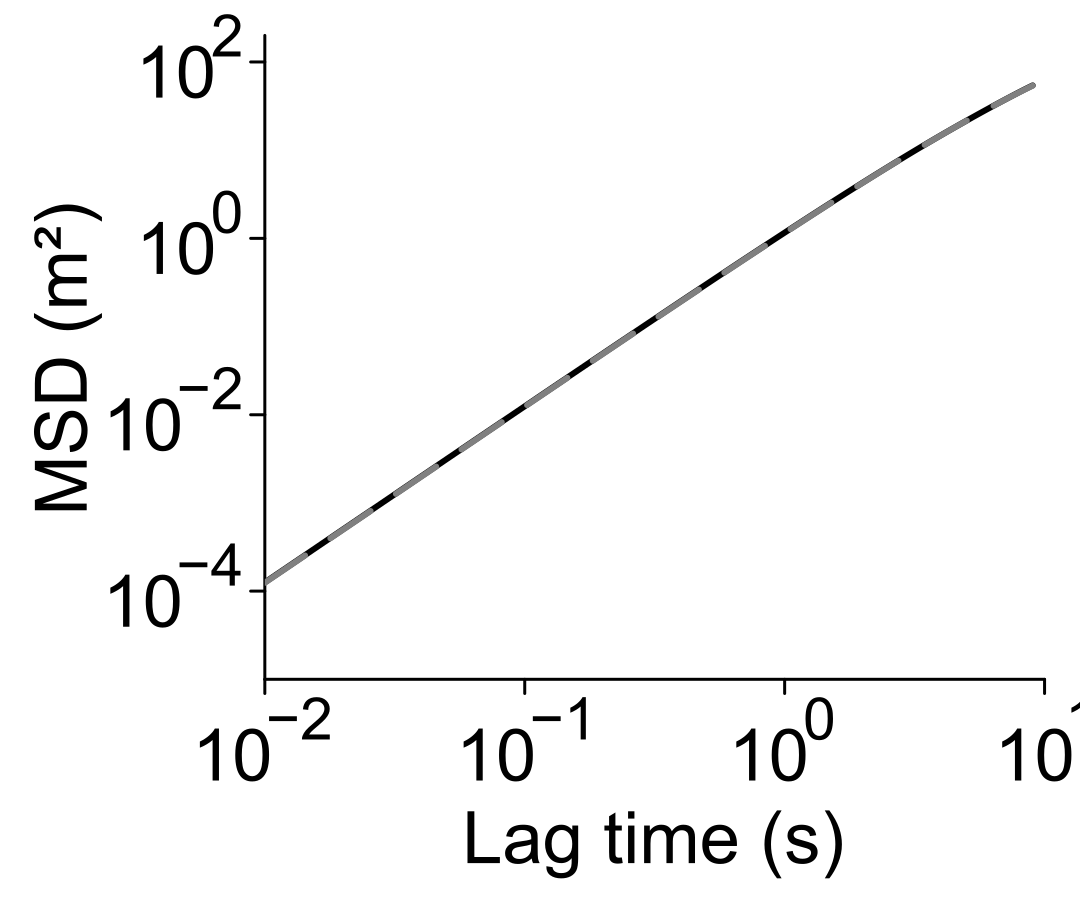

In [14]:
plot(grid=false, size=(360,300), dpi=300,legend=false, tickfontsize=16, 
    xaxis=("Lag time (s)",(0.01,10.0),[0.01,0.1,1, 10],:log),
    yaxis=("MSD (m²)",(1e-5,200),[1e-4,0.01,1, 1e2],:log),)
plot!(collect(0:0.01:9), msd_sim, c=:black; ribbon=SE_sim)
plot!(collect(0:0.01:9), msd_out, c=:gray; ribbon=SE_out,ls=:dash)
current()

### Plot: input data vs learned model - correlation statistics

In [15]:
function autocorr_traj(vel_vec; dTmax=100)
    
    Cx = zeros(dTmax+1)
    Cxx = zeros(dTmax+1)
    Nx = zeros(Int, dTmax+1)
    
    @inbounds@fastmath for pid in eachindex(vel_vec)
        # println(pid)
        M = size(vel_vec[pid],1)
        for dT = 0:dTmax
            mlast = M - dT
            (mlast < 1) && (continue)
            for mm = 1:mlast
                val = dot(vel_vec[pid][mm,:], vel_vec[pid][mm+dT,:]) / mynorm(vel_vec[pid][mm,:]) / mynorm(vel_vec[pid][mm+dT,:]);
                Cx[dT+1] += val
                Cxx[dT+1] += val^2
                Nx[dT+1] += 1
            end
        end
    end
    
    return Cx ./ Nx, sqrt.( Cxx .- Cx.^2 ./ Nx ) ./ Nx
    
end

autocorr_traj (generic function with 1 method)

In [16]:
function speedcorr_traj(f_vec; dTmax=100, v0=1.0)
    
    Cx = zeros(dTmax+1)
    Cxx = zeros(dTmax+1)
    Nx = zeros(Int, dTmax+1)
    
    @inbounds@fastmath for pid in eachindex(f_vec)
        # println(pid)
        M = size(f_vec[pid],1)
        for dT = 0:dTmax
            mlast = M - dT
            (mlast < 1) && (continue)
            for mm = 1:mlast
                val = (f_vec[pid][mm] - v0) * (f_vec[pid][mm+dT] - v0);
                Cx[dT+1] += val
                Cxx[dT+1] += val^2
                Nx[dT+1] += 1
            end
        end
    end
    
    return Cx ./ Nx, sqrt.( Cxx .- Cx.^2 ./ Nx ) ./ Nx
    
end

speedcorr_traj (generic function with 1 method)

In [21]:
corr_mean_sim, corr_SE_sim = autocorr_traj(simVel[1:end];dTmax=900);
corr_mean_out, corr_SE_out = autocorr_traj(outVel[1:end];dTmax=900);
tt=collect(0:length(corr_mean_sim)-1)*0.01;

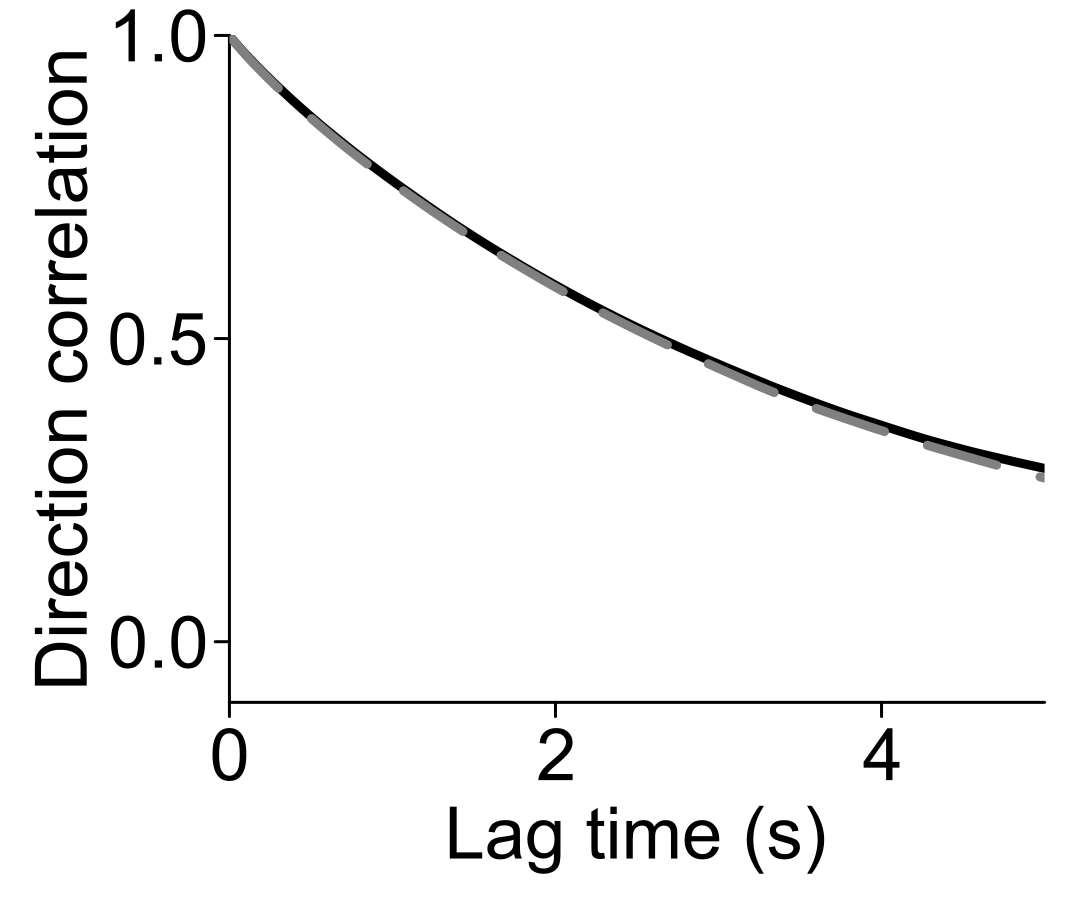

In [25]:
plot(grid=false, size=(360,300), dpi=300, ylim=(-0.1,1),xlabel="Lag time (s)", ylabel="Direction correlation", 
     legend=false, xticks=[0,2,4],yticks=[0,0.5,1], tickfontsize=16, xlim=(0,5), background_color=:transparent);
plot!(tt, corr_mean_sim, lw=3,lc=:black)
plot!(tt, corr_mean_out, lw=3,c=:gray, ls=:dash)
current()

In [23]:
spd_mean_sim, spd_se_sim = speedcorr_traj(simSpeeds; dTmax=500, v0=mean(vcat(simSpeeds...)));
spd_mean_out, spd_se_out = speedcorr_traj(outSpeeds; dTmax=500, v0=mean(vcat(outSpeeds...)));

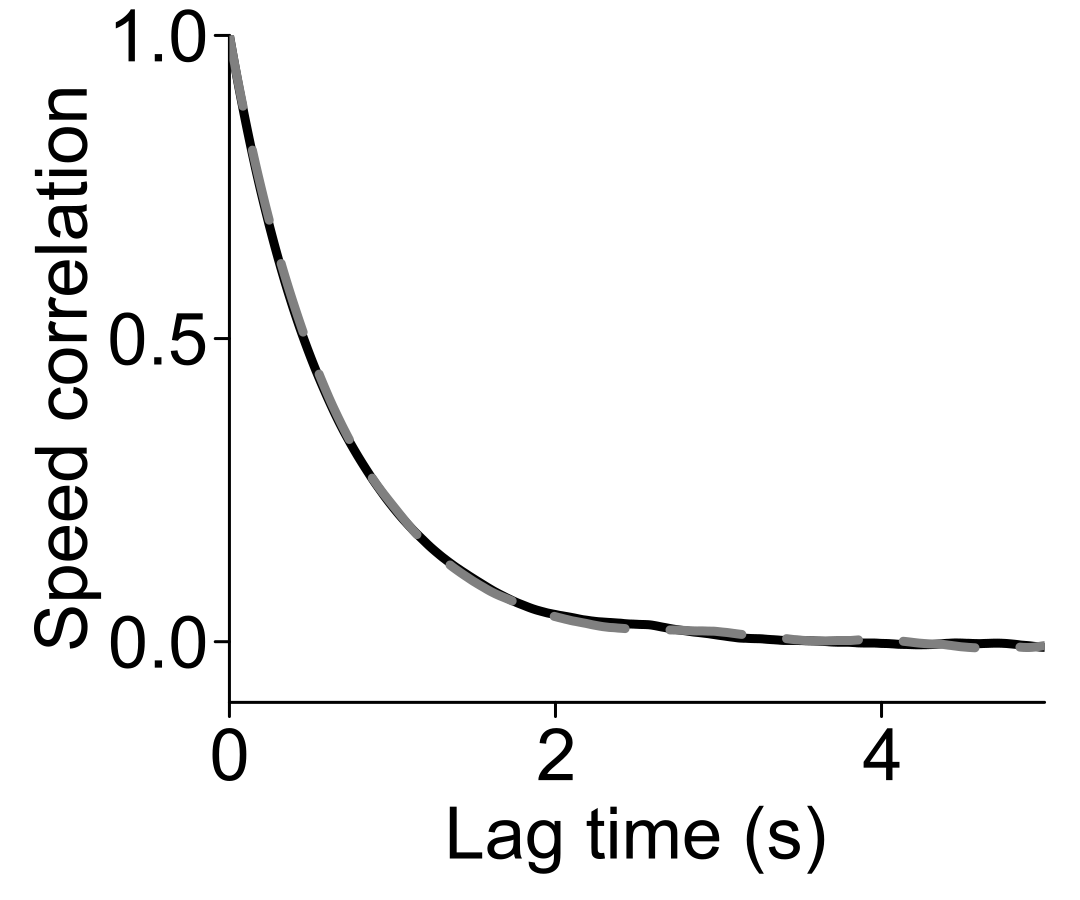

In [26]:
plot(grid=false, size=(360,300), dpi=300, ylim=(-0.1,1),xlabel="Lag time (s)", ylabel="Speed correlation", 
     legend=false, xticks=[0,2,4],yticks=[0,0.5,1], tickfontsize=16, xlim=(0,5), background_color=:transparent);
plot!(tt[1:501], spd_mean_sim./spd_mean_sim[1], lw=3,lc=:black)
plot!(tt[1:501], spd_mean_out./spd_mean_out[1], lw=3,c=:gray, ls=:dash)
current()